## 繪製資料集，並且儲存到資料夾中

![](note_img/complete_visualize.png)

In [1]:
# 創建資料集

import os
import numpy as np
from PIL import Image
from win32comext.mapi.mapiutil import ptTable

from dataloader.heart_calcification.heart_calcification_data_processor import HeartCalcificationDataProcessor
from dataloader.heart_calcification.heart_calcification_results_display import HeartCalcificationResultsDisplay
from config import config

# 初始化数据处理器
data_dir = "D://Paper/RGB_SFM/data/HeartCalcification/basic"  # 请替换为您的数据目录

grid_size = config["heart_calcification"]["grid_size"]
resize_height = config["heart_calcification"]["resize_height"]
need_resize_height = config["heart_calcification"]["need_resize_height"]
threshold = config["heart_calcification"]["threshold"]
contrast_factor = config["heart_calcification"]["contrast_factor"]
enhance_method = config["heart_calcification"]["enhance_method"]

data_processor = HeartCalcificationDataProcessor(grid_size, data_dir, 
need_resize_height, resize_height, threshold, contrast_factor, enhance_method)



Code\runs\train\exp933333333633340333473353333403333333345333333333473343343333433333433333335133339643333533335733
219


In [2]:
# 获取数据字典
data_dict = data_processor.get_data_dict()

# 初始化结果处理器
results_processor = HeartCalcificationResultsDisplay()

# 准备图像和标签数据
images = {}
labels = {}
vessel_masks = {}
calcifications = {}
# 修改这部分代码
for image_name, image_data in data_dict.items():
    # 读取原始图像
    img = Image.open(image_data.image_path)
    img_array = np.array(img)

    # 确保图像是 3 通道 RGB
    if len(img_array.shape) == 2:  # 如果是灰度图
        img_array = np.stack((img_array,) * 3, axis=-1)
    elif img_array.shape[2] == 4:  # 如果是 RGBA
        img_array = img_array[:, :, :3]

    # 确保数据类型是 uint8，范围在 0-255
    if img_array.dtype != np.uint8:
        if img_array.max() <= 1.0:
            img_array = (img_array * 255).astype(np.uint8)
        else:
            img_array = img_array.astype(np.uint8)

    # 创建标签数组
    label_array = np.zeros(image_data.split_count, dtype=int)
    for (i, j), label in image_data.labels.items():
        label_array[i, j] = label
    
    images[image_name] = img_array
    labels[image_name] = label_array
    vessel_masks[image_name] = os.path.join(data_dir,image_data.vessel_mask_file)   
    calcifications[image_name] = os.path.join(data_dir,image_data.calcification_path)   

# 想保存可视化结果的目录
save_dir = f'D://Paper/RGB_SFM/data/HeartCalcification/visual'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
results_processor.visualize_dataset(images, labels, vessel_masks, calcifications, save_dir, enhance_method, grid_size, resize_height)


# 顯示類別的數量
data_processor.display_label_counts()

數據集圖像已保存到: D://Paper/RGB_SFM/data/HeartCalcification/visual\CV00001_1275_LAD_8.png_dataset.png
數據集圖像已保存到: D://Paper/RGB_SFM/data/HeartCalcification/visual\CV00004_1350_LAD_8.png_dataset.png
數據集圖像已保存到: D://Paper/RGB_SFM/data/HeartCalcification/visual\CV00004_1352_LAD_8.png_dataset.png
數據集圖像已保存到: D://Paper/RGB_SFM/data/HeartCalcification/visual\CV00004_1354_D1_8.png_dataset.png
數據集圖像已保存到: D://Paper/RGB_SFM/data/HeartCalcification/visual\CV00004_1356_LCX_8.png_dataset.png
數據集圖像已保存到: D://Paper/RGB_SFM/data/HeartCalcification/visual\CV00004_1358_RCA+PLB_8.png_dataset.png
數據集圖像已保存到: D://Paper/RGB_SFM/data/HeartCalcification/visual\CV00009_1259_LAD1_12.png_dataset.png
數據集圖像已保存到: D://Paper/RGB_SFM/data/HeartCalcification/visual\CV00009_1261_LAD2_12.png_dataset.png
數據集圖像已保存到: D://Paper/RGB_SFM/data/HeartCalcification/visual\CV00009_1263_LAD3_12.png_dataset.png
數據集圖像已保存到: D://Paper/RGB_SFM/data/HeartCalcification/visual\CV00010_1372_RCA@NT_8.png_dataset.png
數據集圖像已保存到: D://Paper/RGB_SFM/data/Hear

# 繪製資料集，小張圖片組成的大圖片
![](note_img/split_img.png)




In [3]:
import os
import numpy as np
from PIL import Image
from dataloader.heart_calcification.heart_calcification_data_processor import HeartCalcificationDataProcessor
from config import config

def merge_images_with_spacing(images, rows, cols, spacing=10):
    # 假設所有圖片的大小是一樣的
    img_height, img_width = images[0].shape

    # 計算合併圖片的總高度和寬度（包括空格）
    total_height = img_height * rows + spacing * (rows - 1)
    total_width = img_width * cols + spacing * (cols - 1)

    # 創建一個大的空白圖像來放置圖片，並填充黑色作為背景
    merged_image = np.zeros((total_height, total_width), dtype=np.uint8)

    # 將每一張圖片放置在合適的位置，並在圖片之間留出空格
    for idx, img in enumerate(images):
        row = idx // cols
        col = idx % cols

        # 計算每張圖片應該放置的起始位置（包括空格）
        start_y = row * (img_height + spacing)
        start_x = col * (img_width + spacing)

        # 將圖片放入合併圖像中
        merged_image[start_y:start_y + img_height, start_x:start_x + img_width] = img

    return merged_image

def save_images_by_label(data_processor: HeartCalcificationDataProcessor):
    # 創建一個字典來存儲每個標籤的圖片
    label_images = {0: [], 1: []}

    dataset = data_processor.get_model_ready_data()

    for idx in range(len(dataset)):
        key, img, label = dataset[idx]

        label_images[label].append(img)
    
    print(len(label_images[0]))
    print(len(label_images[1]))
    
    # 保存圖片到指定的目錄
    for label, images in label_images.items():
        label_save_dir = os.path.join(save_dir, f'label_{label}')
        if not os.path.exists(label_save_dir):
            os.makedirs(label_save_dir)
        
        # 每次處理 100 張圖片並合併
        num_images = len(images)
        img_counter = 0  # 用於記錄合併圖片的編號

        for i in range(0, num_images, 100):
            # 取下一批最多 100 張圖片
            batch_images = images[i:i + 100]
            if len(batch_images) < 100:
                # 不足 100 張的情況下，可能是最後一批，填充成 10x10 的網格
                # 假設用全黑的圖片來補充不足的部分
                empty_image = np.zeros_like(batch_images[0])
                while len(batch_images) < 100:
                    batch_images.append(empty_image)

            # 合併 10x10 的圖片，並在圖片之間留出空格（例如 10 像素）
            merged_image = merge_images_with_spacing(batch_images, 10, 10, spacing=10)

            # 保存合併後的大圖片
            img_path = os.path.join(label_save_dir, f'merged_image_{img_counter}.png')
            Image.fromarray(merged_image).save(img_path)  # 保存圖片
            print(f"已保存合併圖片: {img_path}")

            img_counter += 1  # 更新圖片編號



# 初始化数据处理器
data_dir = "D://Paper/RGB_SFM/data/HeartCalcification/basic"  # 请替换为您的数据目录

grid_size = config["heart_calcification"]["grid_size"]
resize_height = config["heart_calcification"]["resize_height"]
need_resize_height = config["heart_calcification"]["need_resize_height"]
threshold = config["heart_calcification"]["threshold"]
contrast_factor = config["heart_calcification"]["contrast_factor"]
enhance_method = config["heart_calcification"]["enhance_method"]

# 儲存路徑
save_dir = f"D://Paper/RGB_SFM/data/HeartCalcification/enhance_test/split_data_{enhance_method}"


# data_processor = HeartCalcificationDataProcessor(grid_size, data_dir, 
# need_resize_height, resize_height, threshold, contrast_factor, enhance_method)


# 執行保存圖片的函數
save_images_by_label(data_processor)

5903
557
已保存合併圖片: D://Paper/RGB_SFM/data/HeartCalcification/enhance_test/split_data_none\label_0\merged_image_0.png
已保存合併圖片: D://Paper/RGB_SFM/data/HeartCalcification/enhance_test/split_data_none\label_0\merged_image_1.png
已保存合併圖片: D://Paper/RGB_SFM/data/HeartCalcification/enhance_test/split_data_none\label_0\merged_image_2.png
已保存合併圖片: D://Paper/RGB_SFM/data/HeartCalcification/enhance_test/split_data_none\label_0\merged_image_3.png
已保存合併圖片: D://Paper/RGB_SFM/data/HeartCalcification/enhance_test/split_data_none\label_0\merged_image_4.png
已保存合併圖片: D://Paper/RGB_SFM/data/HeartCalcification/enhance_test/split_data_none\label_0\merged_image_5.png
已保存合併圖片: D://Paper/RGB_SFM/data/HeartCalcification/enhance_test/split_data_none\label_0\merged_image_6.png
已保存合併圖片: D://Paper/RGB_SFM/data/HeartCalcification/enhance_test/split_data_none\label_0\merged_image_7.png
已保存合併圖片: D://Paper/RGB_SFM/data/HeartCalcification/enhance_test/split_data_none\label_0\merged_image_8.png
已保存合併圖片: D://Paper/RGB_SFM/d

# 將心臟血管使用 roboflow 標註的檔案，重新命名

In [2]:
import os

def rename_txt_files_in_folder(folder_path):
    # 取得資料夾中的所有檔案
    for filename in os.listdir(folder_path):
        # 檢查是否為 .txt 檔案
        if filename.endswith(".txt"):
            # 使用分割和連接的方式來處理檔名
            parts = filename.split('-')
            new_parts = []
            for i, part in enumerate(parts):
                if i < len(parts) - 1:
                    if parts[i+1].startswith("NT"):
                        new_parts.append(part + '@')
                    elif parts[i+1].startswith("nt"):
                        new_parts.append(part + '@')
                    else:
                        new_parts.append(part + '+')
                else:
                    new_parts.append(part)
            
            new_filename = ''.join(new_parts)
            png_index = new_filename.find('_png')
            if png_index != -1:
                # 如果找到了 .png，將其後的資訊移除
                new_filename = new_filename[:png_index] + "_calcification.txt"
            
            # 重新命名檔案
            os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_filename))
            print(f"已重命名: {filename} -> {new_filename}")

# 指定資料夾路徑
folder_path = "D:\Paper\RGB_SFM\labels"
rename_txt_files_in_folder(folder_path)

已重命名: CV00001_1275_LAD_8_png.rf.c60795de669cb6bb073369cdc2a5500e.txt -> CV00001_1275_LAD_8_calcification.txt
已重命名: CV00004_1350_LAD_8_png.rf.073bf3f4e8ef2ece5772740aab17ae05.txt -> CV00004_1350_LAD_8_calcification.txt
已重命名: CV00004_1352_LAD_8_png.rf.ae65524e3c1dabffa4ee70c0df3c1e84.txt -> CV00004_1352_LAD_8_calcification.txt
已重命名: CV00004_1354_D1_8_png.rf.79c54c56a3716214a5d87aa87c0b6303.txt -> CV00004_1354_D1_8_calcification.txt
已重命名: CV00004_1356_LCX_8_png.rf.4eaf1b9c8632270899aeab3645feec83.txt -> CV00004_1356_LCX_8_calcification.txt
已重命名: CV00004_1358_RCA-PLB_8_png.rf.1920af4de8c9d20c964c193c55a15a49.txt -> CV00004_1358_RCA+PLB_8_calcification.txt
已重命名: CV00009_1259_LAD1_12_png.rf.241fb890fe308a82d39c41eba9a9eaa5.txt -> CV00009_1259_LAD1_12_calcification.txt
已重命名: CV00009_1261_LAD2_12_png.rf.fe9d144bb9d5c9c2c506acf8b6ab12c7.txt -> CV00009_1261_LAD2_12_calcification.txt
已重命名: CV00009_1263_LAD3_12_png.rf.b12b6d5bde1d765b1b649614e44e4f33.txt -> CV00009_1263_LAD3_12_calcification.txt
已

# 混淆舉診繪製

In [5]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchsummary import summary
import os
from torchvision.utils import make_grid
import numpy as np

from config import config, arch
from dataloader import get_dataloader
from models.SFMCNN import SFMCNN
from models.RGB_SFMCNN import RGB_SFMCNN

def load_model():
    models = {'SFMCNN': SFMCNN, 'RGB_SFMCNN':RGB_SFMCNN}
    checkpoint_filename = 'SFMCNN_best'
    checkpoint = torch.load(f'./pth/{config["dataset"]}_pth/{checkpoint_filename}.pth' , weights_only=True)
    model = models[arch['name']](**dict(config['model']['args']))
    model.load_state_dict(checkpoint['model_weights'])
    model.cpu()
    model.eval()
    summary(model, input_size = (config['model']['args']['in_channels'], *config['input_shape']), device='cpu')
    print(model)
    return model

def load_dataloader():
    return get_dataloader(dataset=config['dataset'], root=config['root'] + '/data/',
                          batch_size=config['batch_size'], input_size=config['input_shape'])

def predict(model, dataloader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.argmax(dim=1).cpu().numpy())
    return all_preds, all_labels

def plot_confusion_matrix(pred_labels, true_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        RBF_Conv2d-1            [-1, 100, 9, 9]           2,500
             gauss-2            [-1, 100, 9, 9]               0
     cReLU_percent-3            [-1, 100, 9, 9]               0
               SFM-4            [-1, 100, 3, 3]               0
        RBF_Conv2d-5            [-1, 225, 3, 3]          22,500
             gauss-6            [-1, 225, 3, 3]               0
     cReLU_percent-7            [-1, 225, 3, 3]               0
               SFM-8            [-1, 225, 3, 1]               0
        RBF_Conv2d-9            [-1, 625, 3, 1]         140,625
            gauss-10            [-1, 625, 3, 1]               0
    cReLU_percent-11            [-1, 625, 3, 1]               0
              SFM-12            [-1, 625, 1, 1]               0
       RBF_Conv2d-13           [-1, 1225, 1, 1]         765,625
            gauss-14           [-1, 122

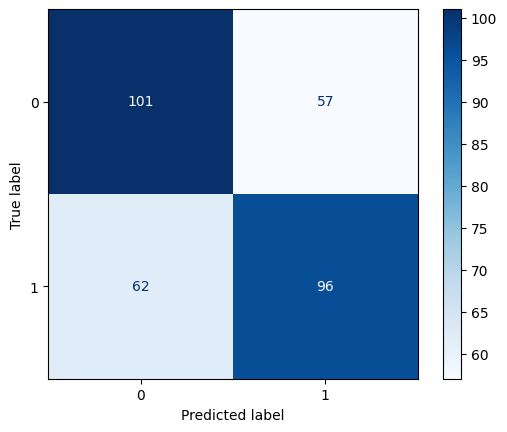

In [2]:
# 主程序
model = load_model()
_, test_dataloader = load_dataloader()
pred_labels, true_labels = predict(model, test_dataloader)
plot_confusion_matrix(pred_labels, true_labels)


In [32]:
from typing import List, Tuple, Any
from dataloader.heart_calcification.heart_calcification_data_processor import HeartCalcificationDataProcessor

def predict(model: Any, data_processor: HeartCalcificationDataProcessor) -> List[Tuple[str, List[int], List[int]]]:
    """
    使用给定的模型对心脏钙化数据进行预测。

    参数:
    model: 用于预测的机器学习模型
    data_processor: HeartCalcificationDataProcessor 实例,包含处理后的数据

    返回:
    List[Tuple[str, List[int], List[int]]]: 预测结果列表,每个元素为 (imageName, true_labels, predicted_labels)
    """

    results = []
    for image_name, image_data in data_processor.data_dict.items():
        images = handle_images(image_data.split_images)
        print(len(images))
        print(images[0].shape)
        predict_labels = model(images)
        results.append((image_name, predict_labels, image_data.labels))

    return results


def handle_images(split_images):
    # 將 List[np.ndarray] 轉換為 np.ndarray
    processed_images = np.array([torch.from_numpy(img).float() / 255.0 for img in split_images])  # 將 np.ndarray 轉換為張量
    processed_images = processed_images.unsqueeze(1)  # 增加一個維度，變為 (260, 1, 45, 45)

    return processed_images  # 返回修改完的 split_images


In [33]:
results = predict(model, data_processor)

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [14]:
model = load_model()
# 初始化数据处理器
data_dir = "D://Paper/RGB_SFM/data/HeartCalcification/basic"  # 请替换为您的数据目录

grid_size = config["heart_calcification"]["grid_size"]
resize_height = config["heart_calcification"]["resize_height"]
need_resize_height = config["heart_calcification"]["need_resize_height"]
threshold = config["heart_calcification"]["threshold"]
contrast_factor = config["heart_calcification"]["contrast_factor"]
enhance_method = config["heart_calcification"]["enhance_method"]

data_processor = HeartCalcificationDataProcessor(grid_size, data_dir, 
need_resize_height, resize_height, threshold, contrast_factor, enhance_method)




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        RBF_Conv2d-1            [-1, 100, 9, 9]           2,500
             gauss-2            [-1, 100, 9, 9]               0
     cReLU_percent-3            [-1, 100, 9, 9]               0
               SFM-4            [-1, 100, 3, 3]               0
        RBF_Conv2d-5            [-1, 225, 3, 3]          22,500
             gauss-6            [-1, 225, 3, 3]               0
     cReLU_percent-7            [-1, 225, 3, 3]               0
               SFM-8            [-1, 225, 3, 1]               0
        RBF_Conv2d-9            [-1, 625, 3, 1]         140,625
            gauss-10            [-1, 625, 3, 1]               0
    cReLU_percent-11            [-1, 625, 3, 1]               0
              SFM-12            [-1, 625, 1, 1]               0
       RBF_Conv2d-13           [-1, 1225, 1, 1]         765,625
            gauss-14           [-1, 122

AttributeError: 'SFMCNN' object has no attribute 'predict'

In [12]:
results[1]

[0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
